# Loading and Customizing a Pre-Trained CNN for Transfer Learning


## Step 1: Setting Up the Environment

1.   List item
2.   List item



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset # Import Subset

# Setup device-agnostic code
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


# Step 2: Loading a Pre-Trained Model

In [ ]:
# Load pre-trained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


## Step 3: Customizing the Model for New Tasks


In [ ]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Change final layer for CIFAR10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

## Step 4: Preparing the Data for Transfer Learning


100%|██████████| 170M/170M [00:03<00:00, 48.1MB/s]


Using a subset of CIFAR10 dataset with 500 training images.


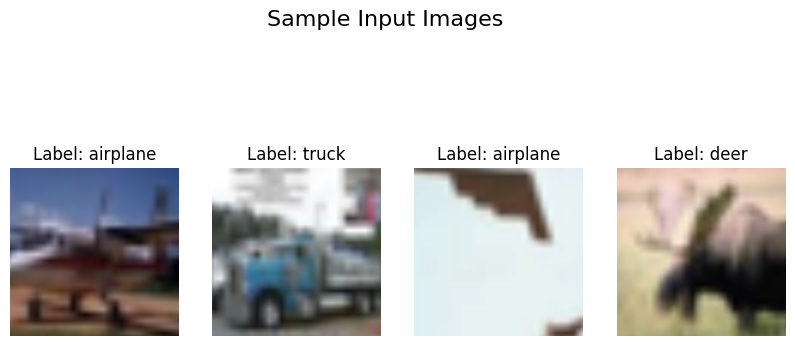

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# --- Changes start here ---

train_dataset_full = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)

# Define the size of the subset you want to use (e.g., 5000 images)
subset_size = 500 # You can adjust this number, e.g., 1000, 2000, 10000

# Create a random subset of the training dataset
# We generate random indices to select a subset of the data
indices = torch.randperm(len(train_dataset_full))[:subset_size]
train_dataset = Subset(train_dataset_full, indices)

# --- Changes end here ---

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Using a subset of CIFAR10 dataset with {len(train_dataset)} training images.")

# --- Input Data Visualization ---
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

num_images_to_show = 4
fig = plt.figure(figsize=(10, 5))
for i in range(num_images_to_show):
    ax = fig.add_subplot(1, num_images_to_show, i + 1)
    # Ensure correct class mapping for subset (use full dataset's classes)
    imshow(images[i])
    ax.set_title(f"Label: {train_dataset_full.classes[labels[i]]}")
plt.suptitle('Sample Input Images', fontsize=16)
plt.show()

## Step 5: Training the Custom Classifier


Epoch 1/5, Loss: 2.3693
Epoch 2/5, Loss: 1.9642
Epoch 3/5, Loss: 1.6109
Epoch 4/5, Loss: 1.3950
Epoch 5/5, Loss: 1.2590
Training finished.


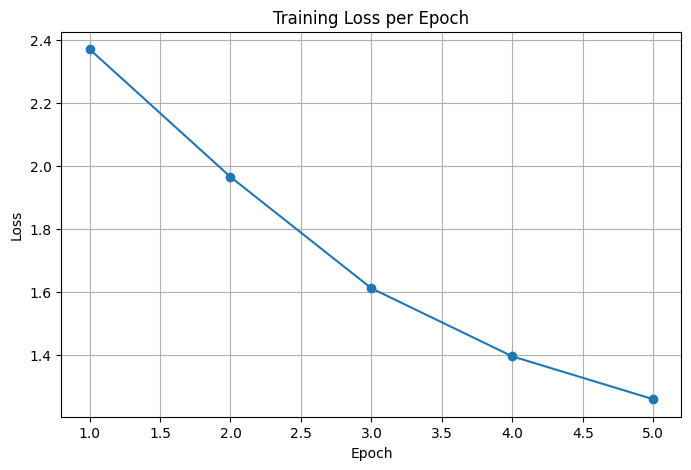

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

model.train()

num_epochs = 5
training_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    training_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

print("Training finished.")

# --- Output Training Loss Visualization ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), training_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()